# Classification with logistic regression in ScikitLearn

[Rain in Australia dataset](https://kaggle.com/jsphyg/weather-dataset-rattle-package) contains approximately 10 years of daily weather observations from numerous Australian weather stations. Here's a small sample from the dataset:

![](https://i.imgur.com/5QNJvir.png)

We want to create an automated system that can use today's weather data for a location to predict whether it will rain tomorrow at that location.

![](https://i.imgur.com/KWfcpcO.png)


## Loading data

Ми будемо використовувати бібліотеку [`opendatasets`](https://github.com/JovianML/opendatasets) для завантаження даних з Kaggle безпосередньо в Jupyter. Давайте встановимо та імпортуємо `opendatasets`.

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od
import os

In [3]:
od.version()

'0.1.22'

In [4]:
dataset_url = 'https://www.kaggle.com/jsphyg/weather-dataset-rattle-package'

In [5]:
isLoaded = True
if not isLoaded:
    od.download(dataset_url)

In [6]:
data_dir = 'data/weather-dataset-rattle-package'

In [7]:
os.listdir(data_dir)

['weatherAUS.csv']

In [8]:
train_csv_dir = data_dir + '/weatherAUS.csv'

Load data from `weatherAUS.csv` with Pandas.

In [9]:
import pandas as pd

In [10]:
raw_df = pd.read_csv(train_csv_dir)

In [11]:
raw_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


The dataset contains over 145,000 rows and 23 columns. The dataset contains columns with dates, numeric values, and categorical values. Our goal is to create a model to predict the value in the `RainTomorrow` column.

Let's check the data types and missing values ​​in different columns.

In [12]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Although we should be able to fill in missing values ​​for most columns, it may be worth discarding rows where `RainTomorrow` or `RainToday` values ​​are missing since one is the target variable and the other is probably very closely related to the target variable.

In [13]:
raw_df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

In [14]:
raw_df.shape

(140787, 23)

In [15]:
use_sample = False
sample_fraction = 0.1
if use_sample:
    raw_df = raw_df.sample(frac=sample_fraction).copy()

## Train/Test split


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
train_val_df, test_df = train_test_split(raw_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)

In [18]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (84471, 23)
val_df.shape : (28158, 23)
test_df.shape : (28158, 23)


For the current dataset, we can use the Date column in the dataset to create another column for the year. We will select the last two years for the test set and one year before them for the validation set.

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

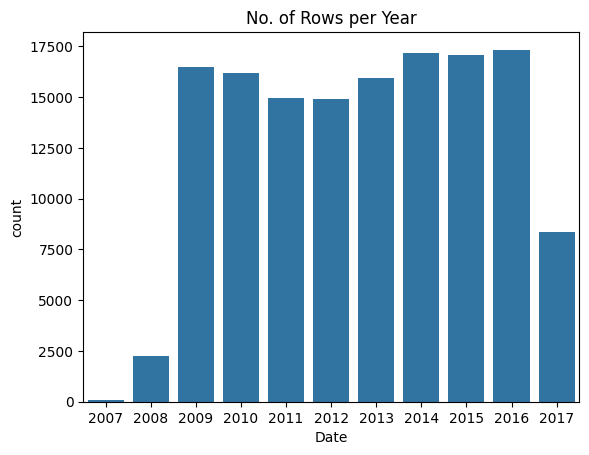

In [20]:
plt.title('No. of Rows per Year')
sns.countplot(x=pd.to_datetime(raw_df.Date).dt.year);

In [21]:
year = pd.to_datetime(raw_df.Date).dt.year

train_df = raw_df[year < 2015]
val_df = raw_df[year == 2015]
test_df = raw_df[year > 2015]

In [22]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (97988, 23)
val_df.shape : (17089, 23)
test_df.shape : (25710, 23)


## Defining input and target columns

In [23]:
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'

In [24]:
print(input_cols)

['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']


In [25]:
target_col

'RainTomorrow'

In [26]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [27]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

In [28]:
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

In [29]:
import numpy as np

In [30]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [31]:
numeric_cols, categorical_cols

(['MinTemp',
  'MaxTemp',
  'Rainfall',
  'Evaporation',
  'Sunshine',
  'WindGustSpeed',
  'WindSpeed9am',
  'WindSpeed3pm',
  'Humidity9am',
  'Humidity3pm',
  'Pressure9am',
  'Pressure3pm',
  'Cloud9am',
  'Cloud3pm',
  'Temp9am',
  'Temp3pm'],
 ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday'])

In [32]:
train_inputs[numeric_cols].describe().round(2)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,97674.00,97801.00,97988.00,61657.00,57942.00,91160.00,97114.00,96919.00,96936.00,96872.00,88876.00,88857.00,63000.00,61966.00,97414.00,97392.00
mean,12.01,23.02,2.37,5.29,7.61,40.22,14.09,18.76,68.63,51.47,1017.51,1015.13,4.30,4.41,16.84,21.54
std,6.35,6.98,8.52,3.95,3.79,13.70,8.98,8.87,19.00,20.76,7.07,7.00,2.87,2.69,6.40,6.83
min,-8.50,-4.10,0.00,0.00,0.00,6.00,0.00,0.00,0.00,0.00,980.50,979.00,0.00,0.00,-5.90,-5.10
25%,7.50,17.90,0.00,2.60,4.80,31.00,7.00,13.00,57.00,37.00,1012.80,1010.40,1.00,2.00,12.20,16.60
50%,11.80,22.40,0.00,4.60,8.50,39.00,13.00,19.00,70.00,52.00,1017.50,1015.10,5.00,5.00,16.60,20.90
75%,16.60,27.90,0.80,7.20,10.60,48.00,19.00,24.00,83.00,66.00,1022.30,1019.90,7.00,7.00,21.40,26.20
max,33.90,48.10,371.00,82.40,14.30,135.00,87.00,87.00,100.00,100.00,1041.00,1039.60,9.00,9.00,40.20,46.10


In [33]:
train_inputs[categorical_cols].nunique()

Location       49
WindGustDir    16
WindDir9am     16
WindDir3pm     16
RainToday       2
dtype: int64

## Filling in missing numerical data

In [34]:
from sklearn.impute import SimpleImputer

In [35]:
imputer = SimpleImputer(strategy = 'mean')

Let's check the number of missing values ​​in each numeric column.

In [36]:
raw_df.shape

(140787, 23)

In [37]:
raw_df[numeric_cols].isna().sum()

MinTemp            468
MaxTemp            307
Rainfall             0
Evaporation      59694
Sunshine         66805
WindGustSpeed     9105
WindSpeed9am      1055
WindSpeed3pm      2531
Humidity9am       1517
Humidity3pm       3501
Pressure9am      13743
Pressure3pm      13769
Cloud9am         52625
Cloud3pm         56094
Temp9am            656
Temp3pm           2624
dtype: int64

In [38]:
train_inputs[numeric_cols].isna().sum()

MinTemp            314
MaxTemp            187
Rainfall             0
Evaporation      36331
Sunshine         40046
WindGustSpeed     6828
WindSpeed9am       874
WindSpeed3pm      1069
Humidity9am       1052
Humidity3pm       1116
Pressure9am       9112
Pressure3pm       9131
Cloud9am         34988
Cloud3pm         36022
Temp9am            574
Temp3pm            596
dtype: int64

In [39]:
imputer.fit(train_inputs[numeric_cols])

SimpleImputer()

In [40]:
list(imputer.statistics_)

[12.0078311526097,
 23.0222022269711,
 2.37293546148508,
 5.289991404057933,
 7.609003831417626,
 40.21587318999561,
 14.09226270156723,
 18.76460755888938,
 68.62874473879673,
 51.46954744404988,
 1017.5137337413925,
 1015.132351891241,
 4.302952380952381,
 4.410676822773779,
 16.835126367873205,
 21.54013779365862]

In [41]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

In [42]:
train_inputs[numeric_cols].isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

## Numerical features Scaling

In [43]:
raw_df[numeric_cols].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,140319.000000,140480.00000,140787.000000,81093.000000,73982.000000,131682.000000,139732.000000,138256.000000,139270.000000,137286.000000,127044.000000,127018.000000,88162.000000,84693.000000,140131.000000,138163.000000
mean,12.184824,23.23512,2.349974,5.472516,7.630540,39.970520,13.990496,18.631141,68.826833,51.449288,1017.654577,1015.257963,4.431161,4.499250,16.987066,21.693183
std,6.403879,7.11450,8.465173,4.189132,3.781729,13.578201,8.886210,8.798096,19.063650,20.807310,7.104867,7.035411,2.886594,2.719752,6.496012,6.937784
min,-8.500000,-4.80000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,7.600000,17.90000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.000000,1010.400000,1.000000,2.000000,12.300000,16.600000
50%,12.000000,22.60000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,16.800000,28.30000,0.800000,7.400000,10.700000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000
max,33.900000,48.10000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000


In [44]:
from sklearn.preprocessing import MinMaxScaler

In [45]:
scaler = MinMaxScaler()

In [46]:
scaler.fit(train_inputs[numeric_cols])

MinMaxScaler()

In [47]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [48]:
train_inputs[numeric_cols].describe().round(2)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00,97988.00
mean,0.48,0.52,0.01,0.06,0.53,0.27,0.16,0.22,0.69,0.51,0.61,0.60,0.48,0.49,0.49,0.52
std,0.15,0.13,0.02,0.04,0.20,0.10,0.10,0.10,0.19,0.21,0.11,0.11,0.26,0.24,0.14,0.13
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.38,0.42,0.00,0.05,0.52,0.19,0.08,0.15,0.57,0.37,0.54,0.53,0.33,0.33,0.39,0.42
50%,0.48,0.51,0.00,0.06,0.53,0.26,0.15,0.22,0.69,0.52,0.61,0.60,0.48,0.49,0.49,0.51
75%,0.59,0.61,0.00,0.07,0.64,0.31,0.22,0.28,0.83,0.65,0.68,0.67,0.67,0.67,0.59,0.61
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


## Categorical data Encoding with One-hot encoder

In [49]:
raw_df[categorical_cols].nunique()

Location       49
WindGustDir    16
WindDir9am     16
WindDir3pm     16
RainToday       2
dtype: int64

In [50]:
from sklearn.preprocessing import OneHotEncoder

In [51]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [52]:
encoder.fit(train_inputs[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [53]:
encoder.categories_

[array(['Adelaide', 'Albany', 'Albury', 'AliceSprings', 'BadgerysCreek',
        'Ballarat', 'Bendigo', 'Brisbane', 'Cairns', 'Canberra', 'Cobar',
        'CoffsHarbour', 'Dartmoor', 'Darwin', 'GoldCoast', 'Hobart',
        'Katherine', 'Launceston', 'Melbourne', 'MelbourneAirport',
        'Mildura', 'Moree', 'MountGambier', 'MountGinini', 'Newcastle',
        'Nhil', 'NorahHead', 'NorfolkIsland', 'Nuriootpa', 'PearceRAAF',
        'Penrith', 'Perth', 'PerthAirport', 'Portland', 'Richmond', 'Sale',
        'SalmonGums', 'Sydney', 'SydneyAirport', 'Townsville',
        'Tuggeranong', 'Uluru', 'WaggaWagga', 'Walpole', 'Watsonia',
        'Williamtown', 'Witchcliffe', 'Wollongong', 'Woomera'],
       dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW', nan], dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW', nan], dtype=object),
 ar

In [54]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['Location_Adelaide', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_Portland', 'Location_Richmond', 'Location_Sale', 'Location_SalmonGums', 'Location_Sydney', 'Location_SydneyAirport', 'Location_Townsville', 'Location_Tuggeranong', 'Location_Uluru', 'Location_WaggaWagga', 'Location_Walpole', 'Location_Watsonia', 'Location_Williamtown', 'Loca

In [55]:
encoder.transform(train_inputs[categorical_cols])[:10]

array([[0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.]])

In [ ]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [57]:
pd.set_option('display.max_columns', None)

In [58]:
test_inputs

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_nan,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir9am_nan,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes
2498,Albury,0.681604,0.798851,0.000000,0.064199,0.532098,ENE,0.372093,NaN,ESE,0.000000,0.080460,0.46,0.17,0.543802,0.498350,0.777778,0.333333,0.694143,0.816406,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2499,Albury,0.693396,0.722222,0.001078,0.064199,0.532098,SSE,0.341085,SSE,SE,0.103448,0.195402,0.54,0.30,0.505785,0.485149,0.888889,0.888889,0.665944,0.718750,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2500,Albury,0.634434,0.521073,0.005930,0.064199,0.532098,ENE,0.325581,ESE,ENE,0.126437,0.448276,0.62,0.67,0.553719,0.590759,0.888889,0.888889,0.600868,0.480469,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2501,Albury,0.608491,0.532567,0.042049,0.064199,0.532098,SSE,0.255814,SE,SSE,0.103448,0.195402,0.74,0.65,0.618182,0.618812,0.888889,0.888889,0.544469,0.521484,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

## LogisticRegression with Scikit-learn


In [59]:
from sklearn.linear_model import LogisticRegression

In [60]:
model = LogisticRegression(solver='liblinear')

In [61]:
model.fit(train_inputs[numeric_cols + encoded_cols], train_targets)

LogisticRegression(solver='liblinear')

Check the weights and intercept of the trained model

In [62]:
print(numeric_cols + encoded_cols)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'Location_Adelaide', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_Portland', 'Location_Richmond', 'Location_Sale', 'Location_

In [63]:
model.coef_.round(2)

array([[ 0.89, -2.85,  3.16,  0.64, -1.65,  6.76, -0.65, -1.42,  0.32,
         5.99,  5.53, -8.96, -0.16,  1.29,  0.47,  1.97,  0.61, -0.56,
         0.47, -0.  ,  0.35, -0.36,  0.17,  0.43, -0.02,  0.02,  0.25,
        -0.02, -0.04, -0.49, -0.13, -0.57, -0.79, -0.26, -0.33, -0.57,
         0.08,  0.  ,  0.06, -0.91, -0.46,  0.01, -0.46, -0.47, -0.07,
         0.19,  0.45,  0.6 ,  0.42, -0.03,  0.25, -0.33,  0.42, -0.06,
        -0.12, -0.74,  0.37,  0.19,  0.18,  0.19, -0.25,  0.01,  0.71,
        -0.8 , -0.2 , -0.17, -0.17, -0.07, -0.23, -0.24, -0.33, -0.17,
        -0.17, -0.12, -0.04, -0.06, -0.1 , -0.1 , -0.23, -0.27, -0.21,
         0.08, -0.33, -0.04, -0.34,  0.02, -0.03,  0.13, -0.07, -0.07,
        -0.42, -0.32, -0.41, -0.2 , -0.07, -0.1 , -0.07, -0.03, -0.28,
        -0.25, -0.16, -0.25,  0.03, -0.32, -0.09,  0.27,  0.21, -0.28,
        -0.25, -0.38, -0.33, -0.38, -0.19, -0.04, -0.29,  0.07, -1.56,
        -1.06]])

In [64]:
print(model.coef_.tolist())

[[0.8943095270714486, -2.8542857288490477, 3.1628982290872374, 0.6408683723779638, -1.649902679479226, 6.7644472689375075, -0.6514669273000289, -1.4202025954347166, 0.32424647678318946, 5.992979518367308, 5.529078154879929, -8.962136607113473, -0.16028697294532815, 1.2880423367985794, 0.470477833829332, 1.9746602706601069, 0.6051494128692542, -0.5584547075398634, 0.4723187801128464, -0.000829734420847835, 0.34859762507469116, -0.35844657621593, 0.17291481810802053, 0.4338625301472574, -0.019417559547533176, 0.023418330200902213, 0.2507161341223146, -0.024656392081834018, -0.0350507818891524, -0.4886289234489213, -0.13328423011593096, -0.5740194940229721, -0.7925340760858475, -0.2571490337840993, -0.33190594488578207, -0.5734492907984393, 0.077004194089126, 0.00404555524363206, 0.061186390972196525, -0.9084206040183923, -0.4590176848592184, 0.00850562235489873, -0.4580285825623369, -0.4685449816127351, -0.07412009904886094, 0.1888440405963666, 0.44742167311286596, 0.6023430645659222, 0.

In [65]:
print(model.intercept_)

[-2.62012596]


## Predictions and model evaluation

In [66]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [67]:
X_train.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_nan,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir9am_nan,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes
0,0.516509,0.517241,0.001617,0.064199,0.532098,0.294574,0.229885,0.275862,0.71,0.22,0.449587,0.463696,0.888889,0.490075,0.494577,0.525391,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.375000,0.559387,0.000000,0.064199,0.532098,0.294574,0.045977,0.252874,0.44,0.25,0.497521,0.475248,0.478106,0.490075,0.501085,0.574219,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.504717,0.570881,0.000000,0.064199,0.532098,0.310078,0.218391,0.298851,0.38,0.30,0.447934,0.490099,0.478106,0.222222,0.583514,0.552734,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.417453,0.614943,0.000000,0.064199,0.532098,0.139535,0.126437,0.103448,0.45,0.16,0.613223,0.557756,0.478106,0.490075,0.520607,0.617188,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [68]:
train_preds = model.predict(X_train)

In [69]:
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [70]:
train_targets

0         No
1         No
2         No
3         No
4         No
          ..
144548    No
144549    No
144550    No
144551    No
144552    No
Name: RainTomorrow, Length: 97988, dtype: object

In [71]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.94462531, 0.05537469],
       [0.94105924, 0.05894076],
       [0.96092455, 0.03907545],
       ...,
       [0.98756259, 0.01243741],
       [0.98341966, 0.01658034],
       [0.87529532, 0.12470468]])

In [72]:
np.argmax(train_probs, axis=1)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

(array([47371., 16128.,  8847.,  5767.,  4391.,  3616.,  3198.,  2937.,
         3048.,  2685.]),
 array([7.37093333e-04, 1.00627329e-01, 2.00517564e-01, 3.00407799e-01,
        4.00298034e-01, 5.00188269e-01, 6.00078504e-01, 6.99968740e-01,
        7.99858975e-01, 8.99749210e-01, 9.99639445e-01]),
 <BarContainer object of 10 artists>)

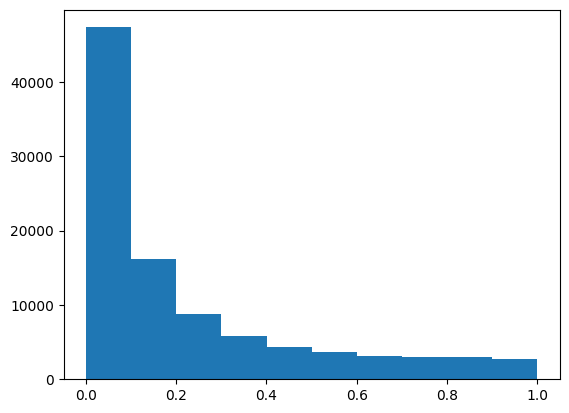

In [73]:
plt.hist(train_probs[:,1])

In [74]:
(train_probs[:,1][:20]>0.2).astype(int)

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0])

In [75]:
(train_probs[:,1][:20]>0.5).astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0])

In [76]:
train_probs[:,1].round(2)[:20]
#  >0.2).astype(int)

array([0.06, 0.06, 0.04, 0.01, 0.28, 0.12, 0.06, 0.02, 0.22, 0.04, 0.02,
       0.91, 0.99, 0.36, 0.28, 0.85, 0.09, 0.03, 0.02, 0.08])

In [77]:
# probabilities for target "No" and "Yes".
train_targets.value_counts(normalize=True)

RainTomorrow
No     0.777544
Yes    0.222456
Name: proportion, dtype: float64

In [78]:
model.classes_

array(['No', 'Yes'], dtype=object)

We can test the accuracy of the model's predictions by calculating the percentage of matching values ​​in `train_preds` and `train_targets`.

This can be done using the `accuracy_score` function from `sklearn.metrics`.

In [79]:
from sklearn.metrics import accuracy_score

In [80]:
accuracy_score(train_targets, train_preds)

0.8520022859942034

In [81]:
from sklearn.metrics import confusion_matrix

In [82]:
confusion_matrix(train_targets, train_preds)

array([[72094,  4096],
       [10406, 11392]], dtype=int64)

In [83]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)

    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    return preds

Accuracy: 85.20%


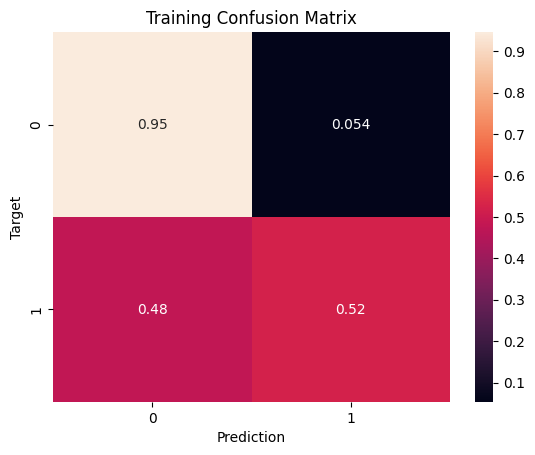

In [84]:
train_preds = predict_and_plot(X_train, train_targets, 'Training')

Model performance on the validation and test data sets

Accuracy: 85.39%


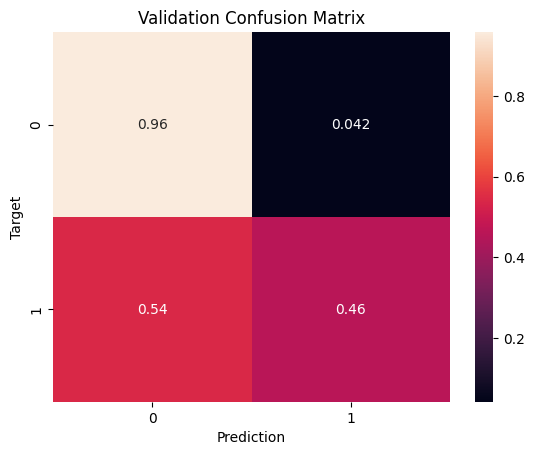

In [85]:
val_preds = predict_and_plot(X_val, val_targets, 'Validation')

Accuracy: 84.22%


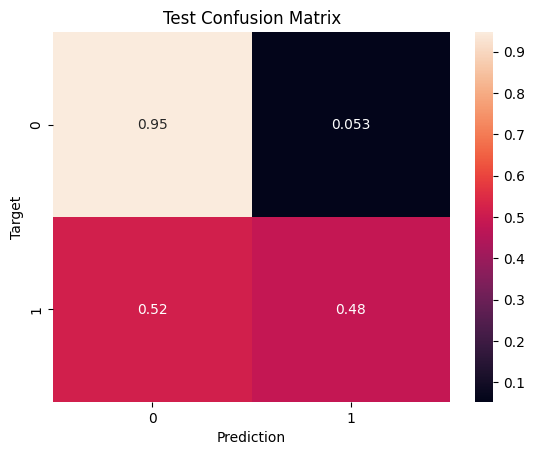

In [86]:
test_preds = predict_and_plot(X_test, test_targets, 'Test')

## F1 metric



In [88]:
from sklearn.metrics import f1_score

In [89]:
preds = model.predict(X_train)
preds[:5], train_targets[:5]

(array(['No', 'No', 'No', 'No', 'No'], dtype=object),
 0    No
 1    No
 2    No
 3    No
 4    No
 Name: RainTomorrow, dtype: object)

In [90]:
f1_score(train_targets, preds, pos_label='Yes')

0.6110604516440487

In [91]:
def get_f1_score(inputs, targets, name=''):
  preds = model.predict(inputs)

  f1_score_ = f1_score(targets, preds, pos_label='Yes')
  print(f"F1 score {name}: {f1_score_:.2f}%")

get_f1_score(X_train, train_targets, 'Training')
get_f1_score(X_val, val_targets, 'Validation')
get_f1_score(X_test, test_targets, 'Test')

F1 score Training: 0.61%
F1 score Validation: 0.57%
F1 score Test: 0.58%


## ROC Curve & AUROC 


In [92]:
from sklearn.metrics import roc_curve, auc

def compute_auroc_and_build_roc(inputs, targets, name=''):
  # Predict probabilities
  y_pred_proba = model.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label='Yes')

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

AUROC for Training: 0.88


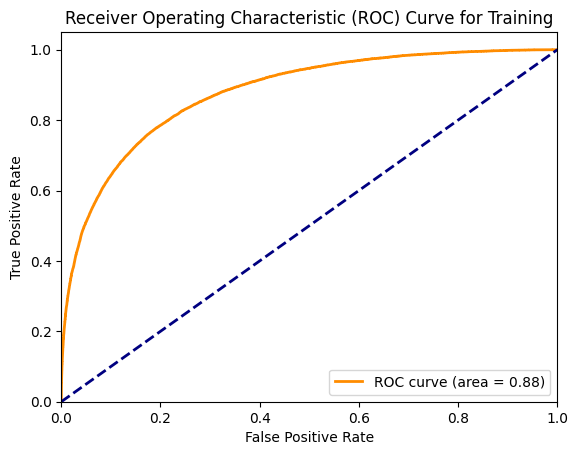

AUROC for Validation: 0.87


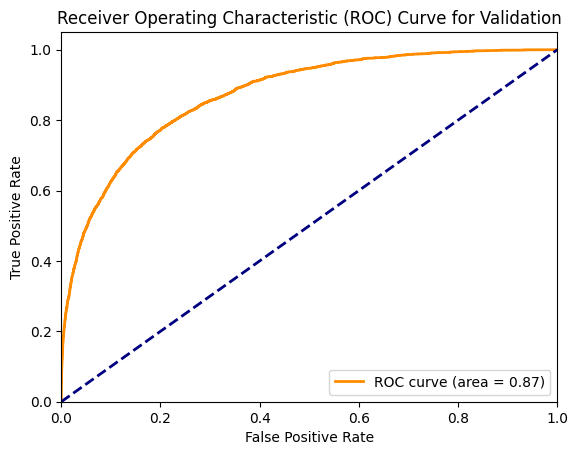

In [93]:
compute_auroc_and_build_roc(X_train, train_targets, 'Training')
compute_auroc_and_build_roc(X_val, val_targets, 'Validation')

## Prediction based on a single input


In [94]:
new_input = {'Date': '2021-06-19',
             'Location': 'Katherine',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

In [95]:
new_input_df = pd.DataFrame([new_input])

In [96]:
new_input_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,2021-06-19,Katherine,23.2,33.2,10.2,4.2,NaN,NNW,52.0,NW,NNE,13.0,20.0,89.0,58.0,1004.8,1001.5,8.0,5.0,25.7,33.0,Yes


Now we need to apply the same transformations that were applied when training the model:

1. Imputation of missing values ​​using the previously created `imputer`
2. Scaling of numerical features using the previously created `scaler`
3. Coding of categorical features using the previously created `encoder`

In [ ]:
new_input_df[numeric_cols] = imputer.transform(new_input_df[numeric_cols])
new_input_df[numeric_cols] = scaler.transform(new_input_df[numeric_cols])
new_input_df[encoded_cols] = encoder.transform(new_input_df[categorical_cols])

In [98]:
X_new_input = new_input_df[numeric_cols + encoded_cols]
X_new_input

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_nan,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir9am_nan,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes
0,0.747642,0.714559,0.027493,0.050971,0.532098,0.356589,0.149425,0.229885,0.89,0.58,0.401653,0.371287,0.888889,0.555556,0.685466,0.744141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [104]:
prediction = model.predict(X_new_input)[0]
prediction

'Yes'

In [103]:
prob = model.predict_proba(X_new_input)[0]
prob

array([0.48103069, 0.51896931])

Function to make predictions for individual inputs

In [105]:
def predict_input(single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    pred = model.predict(X_input)[0]
    prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]
    return pred, prob

In [106]:
new_input = {'Date': '2021-06-19',
             'Location': 'Launceston',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

In [107]:
predict_input(new_input)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_7424\2435838903.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
C:\Users\ASUS\AppData\Local\Temp\ipykernel_7424\2435838903.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
C:\Users\ASUS\AppData\Local\Temp\ipykernel_7424\2435838903.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

('Yes', 0.6482369988998461)

## Saving trained model with `joblib`

In [108]:
import joblib

In [109]:
aussie_rain = {
    'model': model,
    'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [111]:
joblib.dump(aussie_rain, 'models/aussie_rain.joblib')

['models/aussie_rainn.joblib']